### Main 2 

- Outlier Detection and Removal Using IQR: Clean the dataset by removing outliers using the Interquartile Range (IQR) method.
- Feature Reduction Using PCA: Apply Principal Component Analysis (PCA) to reduce the number of features.
- Model Training and Evaluation: Train and evaluate models (KNN, Random Forest, Ada Boosting, Gradient Boosting) using the cleaned and PCA-reduced dataset.

In [1]:
import pandas as pd

# Load the cleaned dataset
df_cleaned_zscore = pd.read_csv('/Users/alexandreribeiro/Downloads/df_cleaned.csv')

df_cleaned_zscore.dtypes

Unnamed: 0                               int64
city                                    object
price                                    int64
lot_size_(m2)                            int64
living_space_size_(m2)                   int64
build_year                               int64
build_type                              object
house_type                              object
house_type_detail                       object
roof                                    object
rooms                                    int64
toilet                                   int64
bathroom                                 int64
floors                                  object
energy_label                            object
position                                object
garden                                  object
estimated_neighbourhood_price_per_m2     int64
dtype: object

In [2]:
# Function to remove outliers using IQR for numerical columns

def remove_outliers_iqr(df):
    numerical_cols = df.select_dtypes(include=['int64']).columns
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

# Remove outliers from the dataset

df_cleaned_iqr = remove_outliers_iqr(df_cleaned_zscore)

# Display the shape of the cleaned dataset

print("Shape of the cleaned dataset:", df_cleaned_iqr.shape)

Shape of the cleaned dataset: (2765, 18)


#### Encoding and scaling

- Encoding categorical variables and scale numerical variables.
- Apply PCA

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Encode categorical variables
X = df_cleaned_iqr.drop(columns=['price'])
y = df_cleaned_iqr['price']
X_encoded = pd.get_dummies(X, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
X_encoded_scaled = scaler.fit_transform(X_encoded)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_encoded_scaled)

# Split the data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

                   With PCA
KNN                0.264385
Random Forest      0.381211
Ada Boosting       0.387832
Gradient Boosting  0.421950


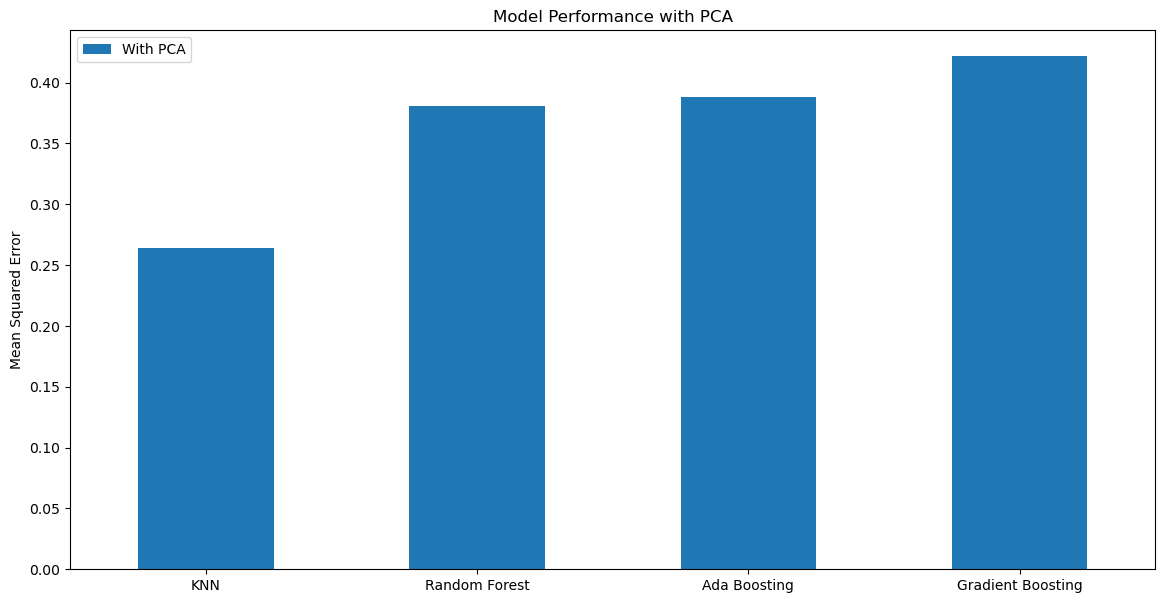

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Define models
models = {
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ada Boosting': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = r2_score(y_test, y_pred)
        results[name] = mse
    return results

# Train and evaluate models with PCA
results_pca = train_and_evaluate(models, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

# Create a DataFrame to compare results
results_df_pca = pd.DataFrame({
    'With PCA': results_pca
})

# Display the results
print(results_df_pca)

# Optional: Plot the results
import matplotlib.pyplot as plt

results_df_pca.plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance with PCA')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=0)
plt.show()

#### 2nd try with high correlated variables

In [5]:
import pandas as pd

# Load the cleaned dataset

df_cleaned_zscore = pd.read_csv('/Users/alexandreribeiro/Downloads/df_cleaned.csv')

# Calculate the correlation matrix for numerical columns

numerical_cols = df_cleaned_zscore.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_cleaned_zscore[numerical_cols].corr()

# Select numerical features with correlation > 0.5 with the target variable (price)

high_corr_numerical_features = correlation_matrix.index[correlation_matrix['price'] > 0.5].tolist()
high_corr_numerical_features.remove('price')

print("High Correlation Numerical Features:", high_corr_numerical_features)

High Correlation Numerical Features: ['living_space_size_(m2)', 'bathroom']


In [6]:
# Using house_type as a categorical feature

top_categorical_feature = 'house_type'

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Function to remove outliers using IQR for numerical columns
def remove_outliers_iqr(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

# Remove outliers from the dataset
df_cleaned_iqr = remove_outliers_iqr(df_cleaned_zscore)

# Select high correlation numerical features
X_high_corr = df_cleaned_iqr[high_corr_numerical_features]

# Encode the top categorical feature
X_categorical = pd.get_dummies(df_cleaned_iqr[top_categorical_feature], drop_first=True)

# Combine the numerical and encoded categorical features
X_combined = pd.concat([X_high_corr, X_categorical], axis=1)

# Scale the combined dataset
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_combined_scaled)

# Split the data
y = df_cleaned_iqr['price']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

                   With PCA
KNN                0.264385
Random Forest      0.381211
Ada Boosting       0.387832
Gradient Boosting  0.421950


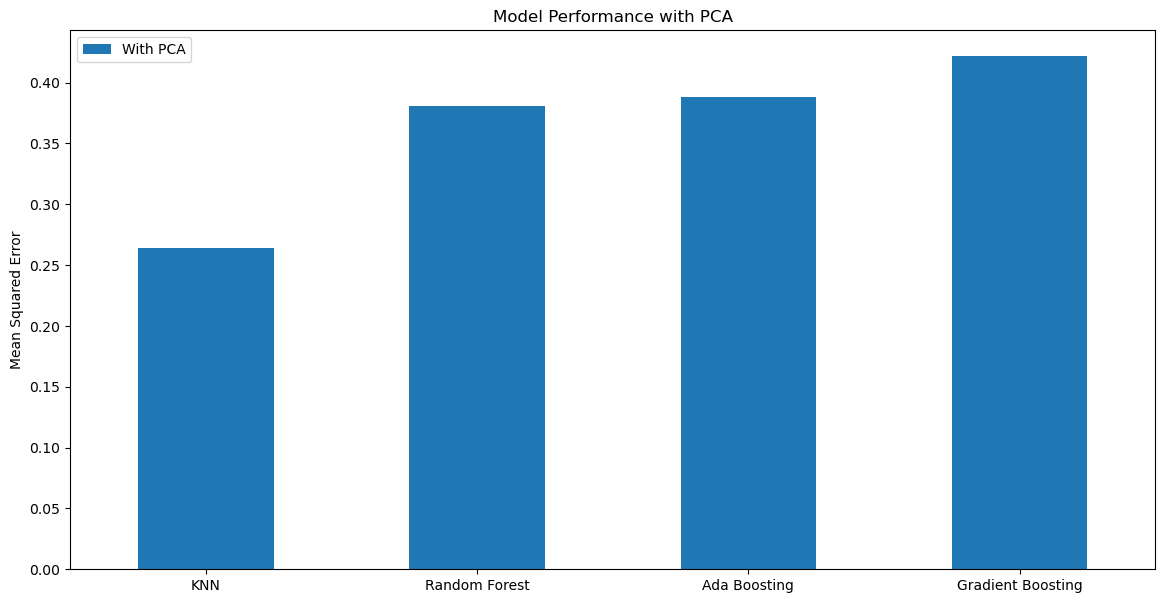

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Define models
models = {
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ada Boosting': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = r2_score(y_test, y_pred)
        results[name] = mse
    return results

# Train and evaluate models with PCA
results_pca = train_and_evaluate(models, X_train_pca, X_test_pca, y_train_pca, y_test_pca)

# Create a DataFrame to compare results
results_df_pca = pd.DataFrame({
    'With PCA': results_pca
})

# Display the results
print(results_df_pca)

# Optional: Plot the results
import matplotlib.pyplot as plt

results_df_pca.plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance with PCA')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=0)
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create the model instances
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

# Create the GridSearchCV instances
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV instances
grid_knn.fit(X_train_pca, y_train_pca)
grid_rf.fit(X_train_pca, y_train_pca)
grid_ada.fit(X_train_pca, y_train_pca)
grid_gb.fit(X_train_pca, y_train_pca)

# Get the best parameters and best scores
best_params_knn = grid_knn.best_params_
best_params_rf = grid_rf.best_params_
best_params_ada = grid_ada.best_params_
best_params_gb = grid_gb.best_params_

best_score_knn = -grid_knn.best_score_
best_score_rf = -grid_rf.best_score_
best_score_ada = -grid_ada.best_score_
best_score_gb = -grid_gb.best_score_

print("Best Parameters for KNN:", best_params_knn)
print("Best MSE for KNN:", best_score_knn)
print("Best Parameters for Random Forest:", best_params_rf)
print("Best MSE for Random Forest:", best_score_rf)
print("Best Parameters for Ada Boosting:", best_params_ada)
print("Best MSE for Ada Boosting:", best_score_ada)
print("Best Parameters for Gradient Boosting:", best_params_gb)
print("Best MSE for Gradient Boosting:", best_score_gb)

Best Parameters for KNN: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Best MSE for KNN: 12747423555.420483
Best Parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best MSE for Random Forest: 11913561817.062
Best Parameters for Ada Boosting: {'learning_rate': 0.01, 'n_estimators': 100}
Best MSE for Ada Boosting: 12082137093.421923
Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best MSE for Gradient Boosting: 11937558351.462105


In [10]:
# Evaluate the best models on the test set
best_knn = grid_knn.best_estimator_
best_rf = grid_rf.best_estimator_
best_ada = grid_ada.best_estimator_
best_gb = grid_gb.best_estimator_

y_pred_knn = best_knn.predict(X_test_pca)
y_pred_rf = best_rf.predict(X_test_pca)
y_pred_ada = best_ada.predict(X_test_pca)
y_pred_gb = best_gb.predict(X_test_pca)

test_mse_knn = mean_squared_error(y_test_pca, y_pred_knn)
test_mse_rf = mean_squared_error(y_test_pca, y_pred_rf)
test_mse_ada = mean_squared_error(y_test_pca, y_pred_ada)
test_mse_gb = mean_squared_error(y_test_pca, y_pred_gb)

print("Test MSE for KNN:", test_mse_knn)
print("Test MSE for Random Forest:", test_mse_rf)
print("Test MSE for Ada Boosting:", test_mse_ada)
print("Test MSE for Gradient Boosting:", test_mse_gb)

Test MSE for KNN: 12419850693.72527
Test MSE for Random Forest: 11020845463.991495
Test MSE for Ada Boosting: 11137007730.749386
Test MSE for Gradient Boosting: 10915076000.155407


#### Implementing feature Engineering

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df_cleaned_zscore = pd.read_csv('/Users/alexandreribeiro/Downloads/df_cleaned.csv')

# Function to remove outliers using IQR for numerical columns
def remove_outliers_iqr(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

# Remove outliers from the dataset
df_cleaned_iqr = remove_outliers_iqr(df_cleaned_zscore)

# Select high correlation numerical features
high_corr_numerical_features = ['living_space_size_(m2)', 'bathroom']
X_high_corr = df_cleaned_iqr[high_corr_numerical_features]

# Encode the top categorical feature
X_categorical = pd.get_dummies(df_cleaned_iqr['house_type'], drop_first=True)

# Create polynomial features for the high correlation numerical variables
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_high_corr = poly.fit_transform(X_high_corr)

# Combine the polynomial features with the encoded categorical features
X_poly_combined = pd.concat([pd.DataFrame(X_poly_high_corr), X_categorical.reset_index(drop=True)], axis=1)

# Ensure all column names are strings
X_poly_combined.columns = X_poly_combined.columns.astype(str)

# Scale the combined dataset
scaler = StandardScaler()
X_poly_combined_scaled = scaler.fit_transform(X_poly_combined)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_poly_pca = pca.fit_transform(X_poly_combined_scaled)

# Split the data
y = df_cleaned_iqr['price']
X_train_poly_pca, X_test_poly_pca, y_train_poly_pca, y_test_poly_pca = train_test_split(X_poly_pca, y, test_size=0.2, random_state=42)

                   With Polynomial Features and PCA
KNN                                    1.301791e+10
Random Forest                          1.163386e+10
Ada Boosting                           1.129842e+10
Gradient Boosting                      1.092003e+10


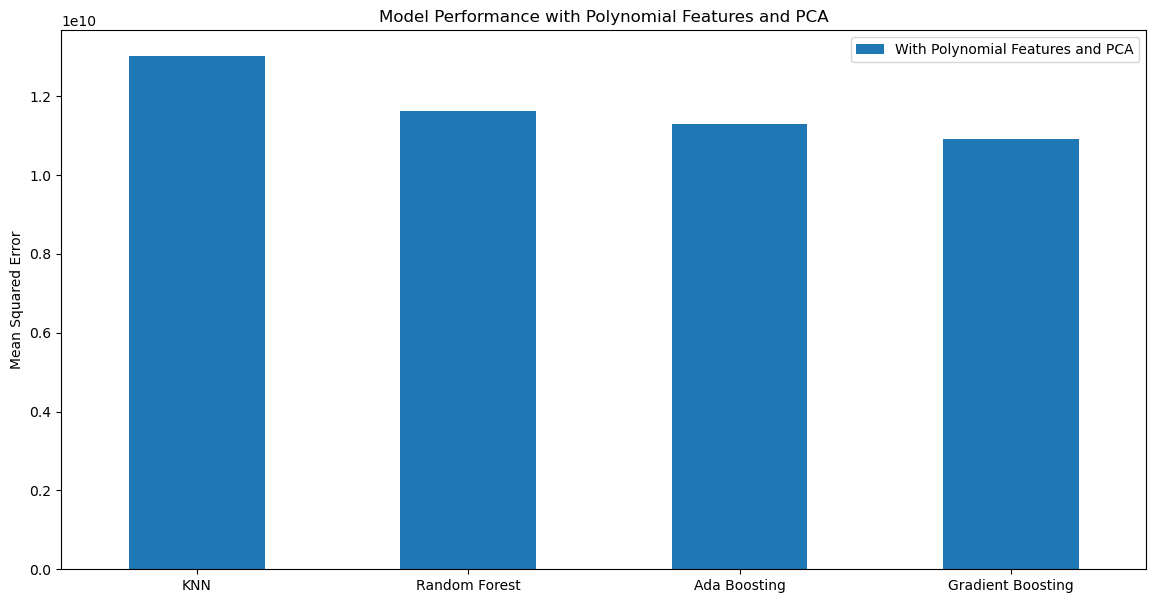

In [12]:
# Train and evaluate models with polynomial features and PCA
results_poly_pca = train_and_evaluate(models, X_train_poly_pca, X_test_poly_pca, y_train_poly_pca, y_test_poly_pca)

# Create a DataFrame to compare results
results_df_poly_pca = pd.DataFrame({
    'With Polynomial Features and PCA': results_poly_pca
})

# Display the results
print(results_df_poly_pca)

# Optional: Plot the results
results_df_poly_pca.plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance with Polynomial Features and PCA')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=0)
plt.show()

In [13]:
from sklearn.linear_model import Ridge, Lasso

# Define Ridge and Lasso models
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)

# Define parameter grids for Ridge and Lasso
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV instances for Ridge and Lasso
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV instances
grid_ridge.fit(X_train_poly_pca, y_train_poly_pca)
grid_lasso.fit(X_train_poly_pca, y_train_poly_pca)

# Get the best parameters and best scores for Ridge and Lasso
best_params_ridge = grid_ridge.best_params_
best_score_ridge = -grid_ridge.best_score_
best_params_lasso = grid_lasso.best_params_
best_score_lasso = -grid_lasso.best_score_

print("Best Parameters for Ridge:", best_params_ridge)
print("Best MSE for Ridge:", best_score_ridge)
print("Best Parameters for Lasso:", best_params_lasso)
print("Best MSE for Lasso:", best_score_lasso)

# Evaluate the best models on the test set
best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_

y_pred_ridge = best_ridge.predict(X_test_poly_pca)
y_pred_lasso = best_lasso.predict(X_test_poly_pca)

test_mse_ridge = mean_squared_error(y_test_poly_pca, y_pred_ridge)
test_mse_lasso = mean_squared_error(y_test_poly_pca, y_pred_lasso)

print("Test MSE for Ridge:", test_mse_ridge)
print("Test MSE for Lasso:", test_mse_lasso)

Best Parameters for Ridge: {'alpha': 100}
Best MSE for Ridge: 11967852505.41786
Best Parameters for Lasso: {'alpha': 100}
Best MSE for Lasso: 11972007143.963108
Test MSE for Ridge: 10846874759.418354
Test MSE for Lasso: 10856246355.831858


In [14]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define base models
base_models = [
    ('knn', KNeighborsRegressor(n_neighbors=9, p=2, weights='uniform')),
    ('rf', RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200, random_state=42)),
    ('ada', AdaBoostRegressor(learning_rate=0.01, n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=300, random_state=42))
]

# Define the meta model
meta_model = LinearRegression()

# Create the stacking ensemble model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Fit the stacking model
stacking_model.fit(X_train_poly_pca, y_train_poly_pca)

# Predict and evaluate the stacking model
y_pred_stacking = stacking_model.predict(X_test_poly_pca)
test_mse_stacking = mean_squared_error(y_test_poly_pca, y_pred_stacking)

print("Test MSE for Stacking Ensemble:", test_mse_stacking)

Test MSE for Stacking Ensemble: 10770159513.744987
